## Traininig of the High Level Feature classifier with TensorFlow/Keras and Petastorm

**4.0 Tensorflow/Keras and Petastorm, HLF classifier** This notebooks trains a dense neural network for the particle classifier using High Level Features. It uses TensorFlow/Keras on a single node. Spark is not used in this case, data is read using the Petastorm library.

To run this notebook we used the following configuration:
* *Software stack*: TensorFlow 1.13.1, Petastorm (`pip install petastom`)
* *Platform*: CentOS 7, Python 3.6


## Create the Keras model

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [2]:
# define the Keras model
keras_model = create_model(50,20,10)

## Load data and train the Keras model

In [3]:
import os
CWD=os.getcwd()

PATH = 'file:///' + CWD +  "/../Data/"

# PATH = "file:<full_path>/SparkDLTrigger/Data/"

file_train_dataset = PATH + "trainUndersampled_HLF_features"
file_test_dataset = PATH + "testUndersampled_HLF_features"

In [4]:
# We use the petastorm libary to load and feed the training and test data in Parquet format
# It makes use TensorFLow tf.data.dataset

from petastorm import make_batch_reader
from petastorm.tf_utils import make_petastorm_dataset

test_dataset = make_batch_reader(file_test_dataset, num_epochs=None)
train_dataset = make_batch_reader(file_train_dataset, num_epochs=None)

In [5]:
# Materialize the test dataset as numpy array
import numpy as np

test_dataset_arrow=test_dataset.dataset.read()
print("Number of test rows:", test_dataset_arrow.num_rows)

%time y_test = np.array(test_dataset_arrow.column("encoded_label").to_pylist())
%time X_test = np.array(test_dataset_arrow.column("HLF_input").to_pylist())

Number of test rows: 856090
CPU times: user 1.86 s, sys: 118 ms, total: 1.98 s
Wall time: 1.87 s
CPU times: user 3.86 s, sys: 286 ms, total: 4.14 s
Wall time: 3.92 s


In [6]:
# Training using tf.dataset and Petastorm
# Petastorm in this configuration uses Parquet row group size as batch size
# The row group size of the training set is 1MB (configured at dataset creation, see provided code)

print("Number of training rows:", train_dataset.dataset.read().num_rows)
with train_dataset as reader_train:
    train_dataset = make_petastorm_dataset(reader_train) \
        .map(lambda x: (tf.reshape(x.HLF_input, [-1, 14]), tf.reshape(x.encoded_label, [-1,3])))
    #
    # train the Keras model
    #
    history = keras_model.fit(train_dataset, steps_per_epoch=1500, \
                                  validation_data=(X_test, y_test), batch_size=128, \
                                  epochs=10, verbose=1)

Number of training rows: 3426083
Epoch 1/10
1500/1500 [==============================] - 49s 33ms/step - loss: 0.3757 - acc: 0.8571 - val_loss: 0.2917 - val_acc: 0.8941
Epoch 2/10
1500/1500 [==============================] - 49s 33ms/step - loss: 0.2818 - acc: 0.8974 - val_loss: 0.2760 - val_acc: 0.8997
Epoch 3/10
1500/1500 [==============================] - 49s 33ms/step - loss: 0.2700 - acc: 0.9019 - val_loss: 0.2649 - val_acc: 0.9043
Epoch 4/10
1500/1500 [==============================] - 49s 33ms/step - loss: 0.2600 - acc: 0.9057 - val_loss: 0.2578 - val_acc: 0.9063
Epoch 5/10
1500/1500 [==============================] - 49s 33ms/step - loss: 0.2545 - acc: 0.9072 - val_loss: 0.2523 - val_acc: 0.9079
Epoch 6/10
1500/1500 [==============================] - 49s 33ms/step - loss: 0.2502 - acc: 0.9083 - val_loss: 0.2496 - val_acc: 0.9083
Epoch 7/10
1500/1500 [==============================] - 50s 33ms/step - loss: 0.2471 - acc: 0.9091 - val_loss: 0.2471 - val_acc: 0.9093
Epoch 8/10
1500

## Performance metrics

<IPython.core.display.Javascript object>


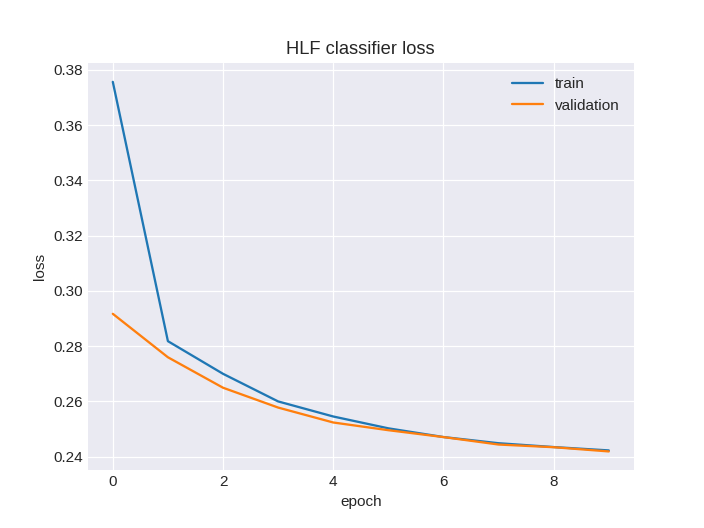

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


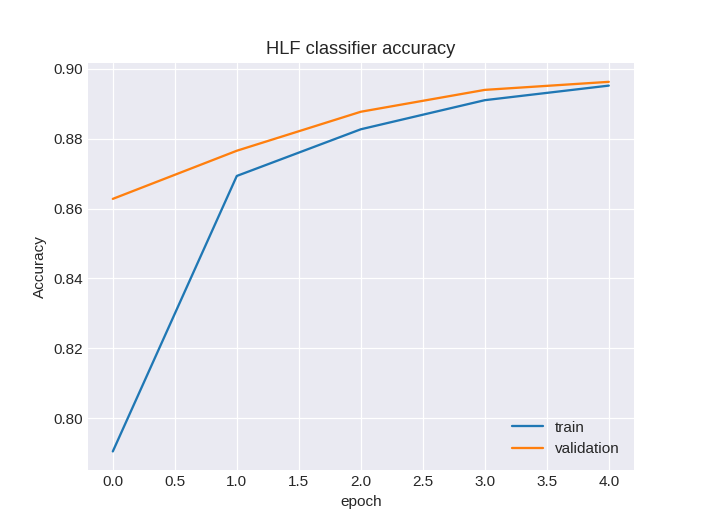

In [34]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [8]:
y_pred=history.model.predict(X_test)
y_true=y_test

In [9]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9110


<IPython.core.display.Javascript object>


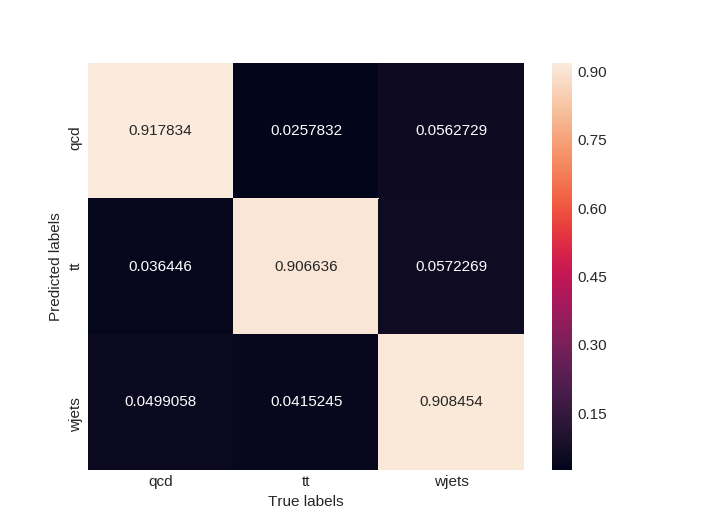

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [11]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [12]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9857079389208885, 1: 0.9835120602752333, 2: 0.9793403909453396}

<IPython.core.display.Javascript object>


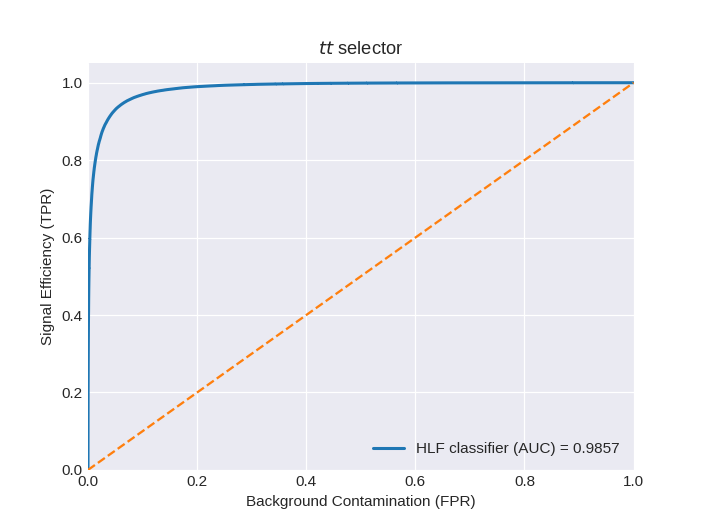

In [13]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()